# Why analyze Kickstarter data
<p>
Kickstarter is a fundraising platform for enterprise projects. Understanding the determinants of success for a Kickstarter fundraiser can help aspiring innovators make decisions that will maximize their chances of success. </p>

# Methodology

<p> This project assumes that the Kickstarter data best fits nonparametric assumptions and does not fit parametric assumptions. This data fits nonparametric assumptions better than parametric assumptions because the data is not normally or (at least) symmetrically distributed and it is subject to extreme outliers. Nonparametric methods do not require assumptions about the population probability distribution functions. There are fewer nonparametric assumptions. Nonparametric assumptions include randomness and independence.
</p>

# Primary Questions
<p> 
Is there an optimal time of year to post a KickStarter campaign? <br>
Are there any particular days of the month or week that are better to post a KickStarter campaign?

</p>

# Steps in analysis
<ol> 
    <li>Import Data </li>
    <li>Clean for Duplicates </li>
        <ol>
            <li>Drop Cancelled or Live Projects on the <strong><em>status</em></strong> variable. We cannot use cancelled or live projects in this analysis. Live projects have yet to conclude and cancelled projects won't yield relevent insights into the population under consideration. </li>
        </ol>
    <li>Fix Inconsistent Data Entry </li>
    <li>Identify Outliers and choose approach </li>
    <ol> 
        <li> It might be worth examining the outliers for common features or comparisons against other data points. </li>
    </ol>
    <li>Create new features </li>
    <li>Measure Skewness </li>
    <li>Test for Normality </li>
    <li>Check Probability Distribution of Variables </li>
    <ol>
        <li>Are users equally likely to post on any given day of the week or month? </li>
        <li>Do the probability distributions of variables segmented by <strong><em>status</em></strong> have the same variance? </li>
    </ol>
    <li>Test the independence of variables </li>
    <li>Test for Joint Significance </li>
</ol>

In [179]:
import pandas as pd
import numpy as np
import datetime
import time
import matplotlib.pyplot as plt
import seaborn as sns
import concurrent.futures
from scipy import stats
from scipy.stats import skew
from scipy.stats import chisquare
from scipy.stats import kruskal
import scikit_posthocs
import warnings
warnings.filterwarnings('ignore')

In [180]:
# load Data
df = pd.read_excel(r"C:\Users\rayde\Desktop\DSI_kickstarterscrape_dataset.xlsx", parse_dates=['funded date'])

In [181]:
# Inspect columns: Should only choose features from the data set that we know prior to the outcome variable. 
# Possible X values - location, category, subcategory, goal, funded date (if decided at the onset o the project)
# Possible Y values - pledged, funded percentage, backers, status
df.columns

Index(['project id', 'name', 'url', 'category', 'subcategory', 'location',
       'status', 'goal', 'pledged', 'funded percentage', 'backers',
       'funded date', 'levels', 'reward levels', 'updates', 'comments',
       'duration'],
      dtype='object')

In [182]:
#View basic stats on data
df.describe()

,project id,goal,pledged,funded percentage,backers,levels,updates,comments,duration
count,4.595700e+04,4.595700e+04,4.594500e+04,45957.000000,45957.000000,45957.000000,45957.00000,45957.000000,45957.000000
mean,1.080800e+09,1.194271e+04,4.980750e+03,1.850129,69.973192,8.004939,4.08508,8.379529,39.995547
std,6.218057e+08,1.887583e+05,5.674162e+04,88.492706,688.628479,4.233907,6.43922,174.015737,17.414458
min,3.940900e+04,1.000000e-02,0.000000e+00,0.000000,0.000000,0.000000,0.00000,0.000000,1.000000
25%,5.438962e+08,1.800000e+03,1.960000e+02,0.044000,5.000000,5.000000,0.00000,0.000000,30.000000
50%,1.078345e+09,4.000000e+03,1.310000e+03,1.000000,23.000000,7.000000,2.00000,0.000000,32.000000
75%,1.621596e+09,9.862000e+03,4.165000e+03,1.115640,59.000000,10.000000,6.00000,3.000000,48.390000
max,2.147460e+09,2.147484e+07,1.026684e+07,15066.000000,87142.000000,80.000000,149.00000,19311.000000,91.960000


In [183]:
#Fill missing values
df.fillna(value=np.nan, inplace=True)

## Browse Duplicates
<p> Verify that duplicates are not just the result of a project running multiple campaigns. Multiple campaigns are acceptable but the same campaign should not be included twice. Drop these. </p>

In [184]:
df[df['project id'].duplicated(keep=False)].sort_values(by='project id').head()

,project id,name,url,category,subcategory,location,status,goal,pledged,funded percentage,backers,funded date,levels,reward levels,updates,comments,duration
45651,2140333236,Imagined Family Heirlooms: An Archive of Inher...,http://www.kickstarter.com/projects/andersonst...,Photography,Photography,"Little Rock, AR",successful,5800.0,8521.0,1.469138,110,2011-07-29 00:53:53+00:00,16,"$10,$20,$35,$50,$75,$100,$150,$200,$225,$300,$...",5,4,67.00
45652,2140333236,Imagined Family Heirlooms: An Archive of Inher...,http://www.kickstarter.com/projects/andersonst...,Photography,Photography,"Little Rock, AR",successful,5800.0,8521.0,1.469138,110,2011-07-29 00:53:53+00:00,16,"$10,$20,$35,$50,$75,$100,$150,$200,$225,$300,$...",5,4,67.00
45653,2140344109,Help Fund Thana Alexa's Debut Album &quot;Ode ...,http://www.kickstarter.com/projects/1024906052...,Music,Jazz,"New York, NY",successful,15000.0,16678.0,1.111867,142,2012-05-20 20:36:57+00:00,16,"$1,$5,$10,$15,$25,$50,$75,$100,$200,$250,$300,...",5,2,32.00
45654,2140344109,Help Fund Thana Alexa's Debut Album &quot;Ode ...,http://www.kickstarter.com/projects/1024906052...,Music,Jazz,"New York, NY",successful,15000.0,16678.0,1.111867,142,2012-05-20 20:36:57+00:00,16,"$1,$5,$10,$15,$25,$50,$75,$100,$200,$250,$300,...",5,2,32.00
45655,2140513451,The Cookie Chew - Changing the Way We Eat a Co...,http://www.kickstarter.com/projects/1650956569...,Food,Food,"San Diego, CA",successful,4500.0,5540.0,1.231111,89,2010-08-24 04:43:00+00:00,5,"$10,$50,$75,$100,$500",14,17,43.27


In [185]:
# Drop Duplicates on Project Id / Drop Cancelled or Live Projects
new_df = df.drop_duplicates(subset=['project id'])
new_df = new_df.query('status == "successful" | status =="failed"')

In [186]:
new_df['status'].unique()

array(['successful', 'failed'], dtype=object)

## Fix inconsistent data entry / importation errors
<ol>
    <li>Look at the unique values of each column to see if there are any data entry errors</li>
    <li>Replace data entry errors using the replace method of the pandas dataframe</li>

In [206]:
new_df.subcategory.unique()

array(['Short Film', 'Board & Card Games', 'Documentary', 'Fashion',
       'Music', 'Illustration', 'Open Software', 'Indie Rock', 'Dance',
       'Fiction', 'Nonfiction', 'Film & Video', 'Theater', 'Games',
       'Art Book', 'Animation', 'Country & Folk', 'Comics', 'Webseries',
       'Technology', 'Performance Art', 'Narrative Film', 'Video Games',
       'Product Design', 'Painting', 'Photography', 'Conceptual Art',
       'Rock', 'Jazz', 'Classical Music', 'Food', 'Art', 'Pop',
       'Journalism', 'Poetry', 'World Music', 'Sculpture', 'Publishing',
       'Electronic Music', "Children's Book", 'Open Hardware',
       'Graphic Design', 'Hip-Hop', 'Public Art', 'Mixed Media',
       'Periodical', 'Crafts', 'Design', 'Digital Art'], dtype=object)

In [207]:
new_df.category.unique()

array(['Film & Video', 'Games', 'Fashion', 'Music', 'Art', 'Technology',
       'Dance', 'Publishing', 'Theater', 'Comics', 'Design',
       'Photography', 'Food'], dtype=object)

In [189]:
new_df = new_df.replace(to_replace="Film &amp; Video", value="Film & Video")
new_df = new_df.replace(to_replace='Board &amp; Card Games', value="Board & Card Games")
new_df = new_df.replace(to_replace='Country &amp; Folk', value="Country & Folk")

In [190]:
new_df.subcategory.unique()

array(['Short Film', 'Board & Card Games', 'Documentary', 'Fashion',
       'Music', 'Illustration', 'Open Software', 'Indie Rock', 'Dance',
       'Fiction', 'Nonfiction', 'Film & Video', 'Theater', 'Games',
       'Art Book', 'Animation', 'Country & Folk', 'Comics', 'Webseries',
       'Technology', 'Performance Art', 'Narrative Film', 'Video Games',
       'Product Design', 'Painting', 'Photography', 'Conceptual Art',
       'Rock', 'Jazz', 'Classical Music', 'Food', 'Art', 'Pop',
       'Journalism', 'Poetry', 'World Music', 'Sculpture', 'Publishing',
       'Electronic Music', "Children's Book", 'Open Hardware',
       'Graphic Design', 'Hip-Hop', 'Public Art', 'Mixed Media',
       'Periodical', 'Crafts', 'Design', 'Digital Art'], dtype=object)

In [191]:
new_df.category.unique()

array(['Film & Video', 'Games', 'Fashion', 'Music', 'Art', 'Technology',
       'Dance', 'Publishing', 'Theater', 'Comics', 'Design',
       'Photography', 'Food'], dtype=object)

In [192]:
new_df['name'] = new_df.name.str.replace("&quot;", '"')

In [193]:
new_df.name.iloc[4]

'Dinner Party - a short film about friendship... and revenge'

# Identify outliers in potential outcome variables
<p> It actually might be worth examining the outliers. What factors may have contributed to the values becoming so extreme? But, we are going to focus less on this and more on what we should do with these outliers. </p>
<p> Options 
<ol>
    <li>Drop all outliers</li>
    <li>Drop some outliers</li>
    <li>Change the values of the outliers</li>
</ol>   
</p>

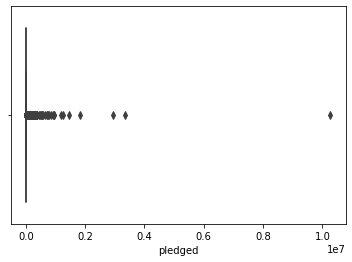

In [194]:
#It looks like we could drop the most extreme one - three data points from pledged. 
# There are some other outliers but that's not necessarily a bad thing. In this particular data set 
# (given that the data is skewed and not normally distributed) 
# dropping too many outliers might homogenize the data set too much. In fact, it could be useful to analyze the outliers 
# on their own.
sns.boxplot(x=df['pledged'])

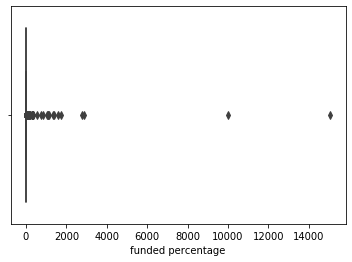

In [195]:
#It looks like we might want to drop at least two data points from pledged
sns.boxplot(x=df['funded percentage'])

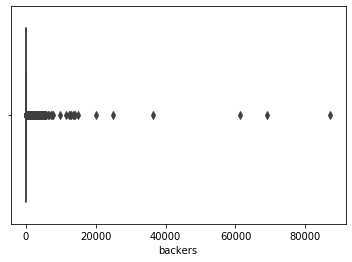

In [196]:
# We should probably drop at least the three data points above 60,000. 
sns.boxplot(x=df['backers'])

In [197]:
df['pledged'].sort_values(ascending=False).head()

10710    10266845.0
41151     3336372.0
42674     2933252.0
11231     1836447.0
35458     1464706.0
Name: pledged, dtype: float64

In [198]:
drop_columns = df['pledged'].sort_values(ascending=False).head(3).index
df.drop(drop_columns, axis=0, inplace=True)
df['pledged'].sort_values(ascending=False).head()

11231    1836447.0
35458    1464706.0
4086     1254120.0
17468    1192793.0
4114      942578.0
Name: pledged, dtype: float64

In [199]:
#Use the Inter Quartile Range to identify outliers
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

project id           1.077617e+09
goal                 8.050000e+03
pledged              3.964750e+03
funded percentage    1.071608e+00
backers              5.400000e+01
levels               5.000000e+00
updates              6.000000e+00
comments             3.000000e+00
duration             1.839000e+01
dtype: float64


In [200]:
# In this particular data set there are a lot of data points that qualify as outliers or projects that have unusually 
# high performance. Thus, the IQR might not be the best strategy for this data set.
df[['pledged', 'funded percentage', 'backers']][(df[['pledged', 'funded percentage', 'backers']] < (Q1 - 1.5 * IQR)) |(df[['pledged', 'funded percentage', 'backers']] > (Q3 + 1.5 * IQR))].dropna()

,pledged,funded percentage,backers
85,31047.0,3.104700,426.0
253,14366.0,9.577607,386.0
443,273725.0,3.649674,5661.0
452,11578.0,4.631200,383.0
503,32121.0,3.212100,261.0
...,...,...,...
45492,16423.0,5.474333,172.0
45661,12800.0,4.266770,332.0
45662,12800.0,4.266770,332.0
45783,17764.0,3.552800,235.0


In [201]:
# Identify outliers by Z-score
for each in ['funded percentage','backers', 'pledged']:
    df[f'z_{each}'] = np.abs(stats.zscore(df[each]))

In [202]:
drop_indices = df[df['z_funded percentage']> 3].sort_values('z_funded percentage', ascending=False).head(2).index
df.drop(drop_indices, axis=0, inplace=True)

In [203]:
drop_indices = df[df['z_backers']> 3].sort_values('z_backers', ascending=False).head(3).index
df.drop(drop_indices, axis=0, inplace=True)

In [204]:
drop_indices = df[df['z_pledged']> 3].sort_values('z_pledged', ascending=False).head(3).index
df.drop(drop_indices, axis=0, inplace=True)

## Create new features out of funded date and location
<p>
    <ol> 
        <li>Posting Date is the funded date minus duration</li>
        <li>Extract Year, Month, Day, Time, and Day of Week from the dates</li>
        <li>Split location into City, State, and Country</li>
        </ol>
        </p>

In [29]:
new_df['duration_td'] = new_df.duration.apply(lambda x: datetime.timedelta(days=x))
new_df[['duration','duration_td']].dtypes

duration               float64
duration_td    timedelta64[ns]
dtype: object

In [30]:
new_df['Posting_Date'] = new_df['funded date'] - new_df['duration_td']
new_df[['Posting_Date','duration','duration_td', 'funded date']].head()

,Posting_Date,duration,duration_td,funded date
0,2011-07-20 19:28:17+00:00,30.00,30 days 00:00:00,2011-08-19 19:28:17+00:00
1,2010-06-15 23:39:48+00:00,47.18,47 days 04:19:12,2010-08-02 03:59:00+00:00
3,2012-03-06 20:57:12+00:00,32.22,32 days 05:16:48,2012-04-08 02:14:00+00:00
4,2011-05-02 15:25:39+00:00,30.00,30 days 00:00:00,2011-06-01 15:25:39+00:00
5,2011-06-01 03:13:48+00:00,21.43,21 days 10:19:12,2011-06-22 13:33:00+00:00


In [31]:
new_df['year_funded'] = new_df['funded date'].dt.year
new_df['month_funded'] = new_df['funded date'].dt.month
new_df['day_funded'] = new_df['funded date'].dt.day
new_df['time_funded'] = new_df['funded date'].dt.time
new_df['dayOfWeek_funded'] = new_df['funded date'].dt.dayofweek
new_df[['year_funded','month_funded', 'day_funded', 'time_funded', 'dayOfWeek_funded']]

,year_funded,month_funded,day_funded,time_funded,dayOfWeek_funded
0,2011,8,19,19:28:17,4
1,2010,8,2,03:59:00,0
3,2012,4,8,02:14:00,6
4,2011,6,1,15:25:39,2
5,2011,6,22,13:33:00,2
...,...,...,...,...,...
45952,2012,3,30,13:57:00,4
45953,2012,4,22,02:12:10,6
45954,2012,1,16,05:00:00,0
45955,2012,5,19,19:44:47,5


In [32]:
new_df['year_posted'] = new_df['Posting_Date'].dt.year
new_df['month_posted'] = new_df['Posting_Date'].dt.month
new_df['day_posted'] = new_df['Posting_Date'].dt.day
new_df['time_posted'] = new_df['Posting_Date'].dt.time
new_df['dayOfWeek_posted'] = new_df['Posting_Date'].dt.dayofweek
new_df[['year_posted','month_posted', 'day_posted', 'time_posted', 'dayOfWeek_posted']]

,year_posted,month_posted,day_posted,time_posted,dayOfWeek_posted
0,2011,7,20,19:28:17,2
1,2010,6,15,23:39:48,1
3,2012,3,6,20:57:12,1
4,2011,5,2,15:25:39,0
5,2011,6,1,03:13:48,2
...,...,...,...,...,...
45952,2012,2,21,18:01:48,1
45953,2012,2,22,03:09:46,2
45954,2011,12,19,21:19:12,0
45955,2012,4,19,19:44:47,3


In [33]:
new_df['city'], new_df['state'] = new_df['location'].str.split(', ', 1).str
new_df[['city', 'state', 'location']]

,city,state,location
0,Columbia,MO,"Columbia, MO"
1,Maplewood,NJ,"Maplewood, NJ"
3,Los Angeles,CA,"Los Angeles, CA"
4,Novi,MI,"Novi, MI"
5,Portland,OR,"Portland, OR"
...,...,...,...
45952,Austin,TX,"Austin, TX"
45953,Los Angeles,CA,"Los Angeles, CA"
45954,Los Angeles,CA,"Los Angeles, CA"
45955,Vero Beach,FL,"Vero Beach, FL"


In [34]:
new_df['city'].unique()

array(['Columbia', 'Maplewood', 'Los Angeles', ..., 'Peaks',
       'Lumberville', 'Lake Oswego'], dtype=object)

In [35]:
new_df['state'].unique()

array(['MO', 'NJ', 'CA', 'MI', 'OR', 'TN', 'IL', nan, 'NY', 'DC', 'ID',
       'FL', 'TX', 'CO', 'ME', 'Taiwan', 'IN', 'Norway', 'MN', 'NC', 'MA',
       'PA', 'CT', 'Chile', 'MD', 'HI', 'VA', 'WA', 'AZ', 'OH', 'NV',
       'Haiti', 'GA', 'AL', 'UT', 'Canada', 'LA', 'SC', 'Ecuador', 'WI',
       'Jamaica', 'Argentina', 'Hong Kong', 'Germany', 'NM', 'NE',
       'Guatemala', 'IA', 'WY', 'Australia', 'RI', 'Sweden', 'OK', 'DE',
       'South Africa', 'AK', 'WV', 'Nepal', 'MT', 'KY', 'VT', 'Kenya',
       'Bosnia and Herzegovina', 'Iceland', 'Mexico', 'KS', 'Hungary',
       'Indonesia', 'China', 'SD', 'Cuba', 'Peru', 'Italy', 'Netherlands',
       'Singapore', 'Ethiopia', 'NH', 'New Zealand', 'France',
       'United Kingdom', 'Austria', 'Turkey', 'AR', 'Mt', 'Congo',
       'Colombia', 'India', 'Mongolia', 'MS', 'Israel', 'Dominica',
       'Finland', 'Czech Republic', 'Japan', 'Virgin Islands, U.S.',
       'Lebanon', 'Armenia', 'Portugal', 'Qatar', 'Morocco', 'Martinique',
       'Pue

In [36]:
new_df = new_df.replace(to_replace='Virginia', value="VA")

In [37]:
x, y = new_df[new_df.state == 'Middleburg, MD']['state'].str.split(', ', 1).str
row_val = list(new_df[new_df.state == 'Middleburg, MD'].index)[0]

new_df.loc[[row_val],['city']] = x
new_df.loc[[row_val], ['state']]= y

In [38]:
new_df['country'] = new_df['state'].replace(to_replace=r'^..{1}$', value="USA", regex=True)
new_df[new_df.country != 'USA'].head()

,project id,name,url,category,subcategory,location,status,goal,pledged,funded percentage,...,time_funded,dayOfWeek_funded,year_posted,month_posted,day_posted,time_posted,dayOfWeek_posted,city,state,country
11,727286,Offline Wikipedia iPhone app,http://www.kickstarter.com/projects/dphiffer/o...,Technology,Open Software,NaN,successful,99.0,145.0,1.464646,...,06:59:59,1,2009,4,25,15:38:23,5,NaN,NaN,NaN
14,893085,Esperanza Farm: A Novel,http://www.kickstarter.com/projects/JesusMaria...,Publishing,Fiction,NaN,failed,6500.0,765.0,0.117692,...,03:59:00,4,2010,5,16,19:49:24,6,NaN,NaN,NaN
29,1512678,Eyes and Ears on English - comedy/English educ...,http://www.kickstarter.com/projects/1787808582...,Film & Video,Film & Video,"Taipei, Taiwan",failed,12000.0,1502.0,0.125167,...,05:15:04,6,2011,4,7,05:15:04,3,Taipei,Taiwan,Taiwan
42,2117470,""" Hugo's There "" - Real News. Unbelievably.",http://www.kickstarter.com/projects/mastermind...,Film & Video,Webseries,"Oslo, Norway",failed,8400.0,25.0,0.002976,...,01:20:25,0,2011,7,25,01:20:25,0,Oslo,Norway,Norway
49,2442649,Dream with Me--A documentary about one year in...,http://www.kickstarter.com/projects/1800556280...,Film & Video,Documentary,NaN,successful,5000.0,5615.0,1.123000,...,01:08:00,4,2009,9,15,03:46:24,1,NaN,NaN,NaN


In [39]:
series_1 = new_df[new_df.country != 'USA']['state'].apply(lambda x: np.nan)
indices= list(new_df[new_df.country != 'USA'].index)
new_df.loc[indices, ['state']] = series_1

In [40]:
new_df['state'].unique()

array(['MO', 'NJ', 'CA', 'MI', 'OR', 'TN', 'IL', nan, 'NY', 'DC', 'ID',
       'FL', 'TX', 'CO', 'ME', 'IN', 'MN', 'NC', 'MA', 'PA', 'CT', 'MD',
       'HI', 'VA', 'WA', 'AZ', 'OH', 'NV', 'GA', 'AL', 'UT', 'LA', 'SC',
       'WI', 'NM', 'NE', 'IA', 'WY', 'RI', 'OK', 'DE', 'AK', 'WV', 'MT',
       'KY', 'VT', 'KS', 'SD', 'NH', 'AR', 'Mt', 'MS', 'ND'], dtype=object)

In [41]:
new_df['country'].unique()

array(['USA', nan, 'Taiwan', 'Norway', 'Chile', 'Haiti', 'Canada',
       'Ecuador', 'Jamaica', 'Argentina', 'Hong Kong', 'Germany',
       'Guatemala', 'Australia', 'Sweden', 'South Africa', 'Nepal',
       'Kenya', 'Bosnia and Herzegovina', 'Iceland', 'Mexico', 'Hungary',
       'Indonesia', 'China', 'Cuba', 'Peru', 'Italy', 'Netherlands',
       'Singapore', 'Ethiopia', 'New Zealand', 'France', 'United Kingdom',
       'Austria', 'Turkey', 'Congo', 'Colombia', 'India', 'Mongolia',
       'Israel', 'Dominica', 'Finland', 'Czech Republic', 'Japan',
       'Virgin Islands, U.S.', 'Lebanon', 'Armenia', 'Portugal', 'Qatar',
       'Morocco', 'Martinique', 'Puerto Rico', 'Afghanistan', 'Denmark',
       'Tanzania', 'Kazakhstan', 'Zambia', 'Switzerland', 'Egypt',
       'Svalbard and Jan Mayen', 'Liberia', 'Ghana', 'Nicaragua',
       'Russia', 'Ukraine', 'Bulgaria', 'South Korea', 'Brazil', 'Rwanda',
       'Spain', 'Costa Rica', 'Philippines', 'Pakistan', 'El Salvador',
       'Panama', 

In [42]:
new_df['country'] = new_df['country'].astype('str')
new_df[new_df.country == 'nan'][['location', 'country']].head()

,location,country
11,NaN,nan
14,NaN,nan
49,NaN,nan
98,NaN,nan
100,NaN,nan


In [43]:
series1 = new_df[new_df['country']=='nan']['country'].apply(lambda x: np.nan)
indices = series1.index
new_df.loc[indices, ['country']] = series_1

In [44]:
new_df.loc[indices, ['country']].head()

,country
11,NaN
14,NaN
49,NaN
98,NaN
100,NaN


## Create Dummy Variables Using LabelEncoder()

In [45]:
obj_cols = ['category', 'subcategory', 'status', 'year_posted', 'year_funded', 'month_posted', 'month_funded']
label_encoder = LabelEncoder()
for col in obj_cols:
    try:
        new_df[col+"_dummy"] = label_encoder.fit_transform(new_df[col])
    except:
        print('problem with' + col)

In [46]:
countries = new_df.country
country_counts = countries.value_counts()

mask = countries.isin(country_counts[country_counts < 10].index)

# Label all other categories as Other
countries[mask] = 'Other'

In [47]:
new_df['country'] = new_df['country'].astype('str')
new_df.country
new_df['country_dummy'] = label_encoder.fit_transform(new_df['country'])

In [48]:
new_df[['status','status_dummy']]

,status,status_dummy
0,successful,1
1,failed,0
3,successful,1
4,failed,0
5,successful,1
...,...,...
45952,successful,1
45953,failed,0
45954,successful,1
45955,failed,0


In [49]:
new_df.describe()

,project id,goal,pledged,funded percentage,backers,levels,updates,comments,duration,duration_td,...,day_posted,dayOfWeek_posted,category_dummy,subcategory_dummy,status_dummy,year_posted_dummy,year_funded_dummy,month_posted_dummy,month_funded_dummy,country_dummy
count,4.184100e+04,4.184100e+04,4.184100e+04,41841.000000,41841.000000,41841.000000,41841.000000,41841.000000,41841.000000,41841,...,41841.000000,41841.000000,41841.000000,41841.000000,41841.000000,41841.000000,41841.000000,41841.000000,41841.000000,41841.000000
mean,1.078276e+09,1.041084e+04,5.128665e+03,1.980354,71.098731,7.950646,4.335580,8.327287,40.232153,40 days 05:34:17.990965799,...,15.222413,2.577735,6.258072,26.105423,0.547358,2.025501,2.123205,4.918358,5.079993,49.872493
std,6.197736e+08,1.480363e+05,5.916179e+04,92.728555,713.994952,4.192497,6.628569,175.451017,17.786219,17 days 18:52:09.326775168,...,8.819130,1.820043,3.160544,13.910777,0.497758,0.754904,0.744352,3.488458,3.331319,6.445682
min,3.940900e+04,1.000000e-02,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1 days 00:00:00,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.426141e+08,1.650000e+03,2.200000e+02,0.051667,5.000000,5.000000,0.000000,0.000000,30.000000,30 days 00:00:00,...,8.000000,1.000000,5.000000,14.000000,0.000000,2.000000,2.000000,2.000000,2.000000,51.000000
50%,1.077801e+09,4.000000e+03,1.450000e+03,1.005167,25.000000,7.000000,2.000000,1.000000,32.080000,32 days 01:55:12,...,15.000000,2.000000,6.000000,27.000000,1.000000,2.000000,2.000000,4.000000,4.000000,51.000000
75%,1.616992e+09,8.800000e+03,4.400000e+03,1.130000,61.000000,10.000000,6.000000,3.000000,49.080000,49 days 01:55:12,...,23.000000,4.000000,8.000000,41.000000,1.000000,3.000000,3.000000,8.000000,8.000000,51.000000
max,2.147460e+09,2.147484e+07,1.026684e+07,15066.000000,87142.000000,80.000000,149.000000,19311.000000,91.960000,91 days 23:02:24,...,31.000000,6.000000,12.000000,48.000000,1.000000,3.000000,3.000000,11.000000,11.000000,54.000000


In [174]:
columns = ['goal', 'pledged', 'funded percentage', 'backers', 'levels', 
           'updates', 'comments', 'duration', 'Posting_Date', 'month_posted', 
          'day_posted', 'dayOfWeek_posted','category_dummy', 'subcategory_dummy']
describe_by_status = pd.DataFrame()
for column in columns:
    for status in [0, 1]:
        describe_by_status[f'{column}_{status}'] = new_df[new_df['status_dummy']==status][column].describe()

In [177]:
#Look at the difference in standard deviation of the successful and unsuccessful projects
describe_by_status

,goal_0,goal_1,pledged_0,pledged_1,funded percentage_0,funded percentage_1,backers_0,backers_1,levels_0,levels_1,...,month_posted_0,month_posted_1,day_posted_0,day_posted_1,dayOfWeek_posted_0,dayOfWeek_posted_1,category_dummy_0,category_dummy_1,subcategory_dummy_0,subcategory_dummy_1
count,1.893900e+04,22902.000000,18939.000000,2.290200e+04,18939.000000,22902.000000,18939.000000,22902.000000,18939.000000,22902.000000,...,18939.000000,22902.000000,18939.000000,22902.000000,18939.000000,22902.000000,18939.000000,22902.000000,18939.000000,22902.000000
mean,1.636516e+04,5486.856735,897.392471,8.627751e+03,0.104839,3.531326,12.570885,119.498821,7.287608,8.498952,...,5.942605,5.898306,15.335921,15.128548,2.638576,2.527421,6.175088,6.326696,25.589471,26.532093
std,2.194686e+05,12379.293920,2843.505734,7.975562e+04,0.150140,125.316534,27.160113,962.078858,3.740884,4.458296,...,3.492812,3.484802,8.868666,8.777041,1.831379,1.809111,3.104164,3.204864,13.802958,13.985239
min,5.000000e-01,0.010000,0.000000,1.000000e+00,0.000000,0.999830,0.000000,1.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.500000e+03,1300.000000,20.000000,1.656000e+03,0.002857,1.033750,1.000000,29.000000,5.000000,6.000000,...,3.000000,3.000000,8.000000,8.000000,1.000000,1.000000,5.000000,5.000000,14.000000,14.000000
50%,5.000000e+03,3000.000000,170.000000,3.500000e+03,0.037388,1.109823,4.000000,52.000000,7.000000,8.000000,...,5.000000,5.000000,15.000000,15.000000,3.000000,2.000000,5.000000,7.000000,27.000000,27.000000
75%,1.200000e+04,6000.000000,740.000000,7.259500e+03,0.148536,1.320002,14.000000,96.000000,9.000000,10.000000,...,9.000000,9.000000,23.000000,22.000000,4.000000,4.000000,8.000000,8.000000,39.000000,41.000000
max,2.147484e+07,900000.000000,112287.000000,1.026684e+07,1.079700,15066.000000,882.000000,87142.000000,70.000000,80.000000,...,12.000000,12.000000,31.000000,31.000000,6.000000,6.000000,12.000000,12.000000,48.000000,48.000000


In [50]:
#create interaction between month and year
new_df['year_month_posted'] = new_df['year_posted'].astype('str') + "_" + new_df['month_posted_dummy'].astype('str')
new_df['year_month_posted'] = label_encoder.fit_transform(new_df['year_month_posted'])
new_df['year_month_posted'].describe()

count    41841.000000
mean        26.054994
std          8.005827
min          0.000000
25%         21.000000
50%         27.000000
75%         33.000000
max         37.000000
Name: year_month_posted, dtype: float64

In [52]:
#create interaction between month and year
new_df['year_month_funded'] = new_df['year_funded'].astype('str') + "_" + new_df['month_funded_dummy'].astype('str')
new_df['year_month_funded'] = label_encoder.fit_transform(new_df['year_month_funded'])
new_df['year_month_funded'].describe()

count    41841.000000
mean        26.390956
std          7.909144
min          0.000000
25%         22.000000
50%         28.000000
75%         33.000000
max         37.000000
Name: year_month_funded, dtype: float64

# Exploratory Analysis

## Check Skewness and test for normal distribution
<p> Notes: 
    <ul> 
        <li>mean greater than median, positively skewed</li> 
        <li>mean less than median, negatively skewed</li> 
        <li>mean = median, symmetrical distribution </li>
    </ul>
        </p>

<p> The normal test tests if the distribution of the variable differs from the normal distribution - This is important because the results indicate whether parametric or nonparametric statistical tests should be used. </p>

In [53]:
x_vars = ['goal', 'updates', 'comments', 'duration', 'year_posted_dummy', 'year_funded_dummy', 
          'month_posted_dummy', 'month_funded_dummy','day_posted', 'day_funded', 'dayOfWeek_posted', 'dayOfWeek_funded', 'category_dummy', 
          'subcategory_dummy', 'year_month_posted', 'year_month_funded']
y_vars = ['pledged', 'funded percentage', 'backers', 'status_dummy']

In [54]:
new_df.skew(axis = 0, skipna = True)

project id             -0.008691
goal                  132.451022
pledged               134.091965
funded percentage     134.417943
backers                85.971300
levels                  2.607894
updates                 3.907637
comments               71.633083
duration                1.066485
year_funded            -0.445769
month_funded            0.288752
day_funded              0.057872
dayOfWeek_funded       -0.108342
year_posted            -0.385792
month_posted            0.287381
day_posted              0.052742
dayOfWeek_posted        0.233772
category_dummy         -0.281979
subcategory_dummy      -0.074178
status_dummy           -0.190294
year_posted_dummy      -0.385792
year_funded_dummy      -0.445769
month_posted_dummy      0.287381
month_funded_dummy      0.288752
country_dummy          -5.658267
year_month_posted      -0.773060
year_month_funded      -0.832694
dtype: float64

In [55]:
#Reject the null that they are normally distributed
for each in x_vars:
    print(f"{each}:", stats.normaltest(new_df[each],axis = 0, nan_policy='omit'))
for each in y_vars:
    print(f"{each}:", stats.normaltest(new_df[each],axis = 0, nan_policy='omit'))

goal: NormaltestResult(statistic=181221.97474867204, pvalue=0.0)
updates: NormaltestResult(statistic=35981.269196937435, pvalue=0.0)
comments: NormaltestResult(statistic=148916.91323430266, pvalue=0.0)
duration: NormaltestResult(statistic=6185.700723610547, pvalue=0.0)
year_posted_dummy: NormaltestResult(statistic=1166.7593889551026, pvalue=4.3794324700114634e-254)
year_funded_dummy: NormaltestResult(statistic=1611.3934272908994, pvalue=0.0)
month_posted_dummy: NormaltestResult(statistic=48094.14473316772, pvalue=0.0)
month_funded_dummy: NormaltestResult(statistic=14727.479581701287, pvalue=0.0)
day_posted: NormaltestResult(statistic=30782.809488430856, pvalue=0.0)
day_funded: NormaltestResult(statistic=36756.83174117571, pvalue=0.0)
dayOfWeek_posted: NormaltestResult(statistic=9129.33885408962, pvalue=0.0)
dayOfWeek_funded: NormaltestResult(statistic=63622.4356716953, pvalue=0.0)
category_dummy: NormaltestResult(statistic=1072.5833590653822, pvalue=1.2344766744891414e-233)
subcategory

## Look at Relationship between outcome variables and duration
<p> There seems to be a consistent jump in pledged, percent funded, and backers at around 30 days duration. </p>

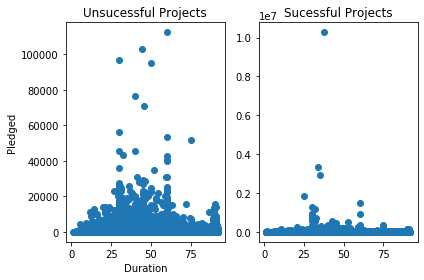

In [77]:
y1 = new_df[new_df['status_dummy']==0]['pledged']
y2 = new_df[new_df['status_dummy']==1]['pledged']

x1 = new_df[new_df['status_dummy']==0]['duration']
x2 = new_df[new_df['status_dummy']==1]['duration']

plt.subplot(1, 2, 1)
plt.scatter(x1, y1)
plt.xlabel('Duration')
plt.ylabel('Pledged')
plt.title('Unsucessful Projects')

plt.subplot(1, 2, 2)
plt.scatter(x2, y2)
plt.title('Sucessful Projects')

plt.tight_layout()
plt.show()

In [78]:
print("Independent Variance\n----------")
print("Unsuccessful = ", x1.var())
print("Successful = ", x2.var())
print("\nDependent Variance\n----------")
print("Unsuccessful = ",y1.var())
print("Successful = ", y2.var())

Independent Variance
----------
Unsuccessful =  349.886916767045
Successful =  277.23816741709203

Dependent Variance
----------
Unsuccessful =  8085524.857734167
Successful =  6360958490.897638


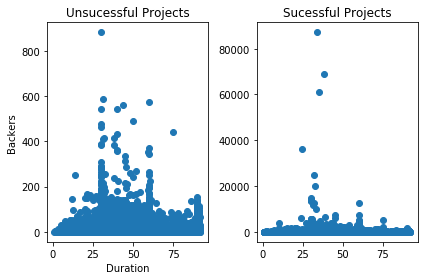

In [79]:
y1 = new_df[new_df['status_dummy']==0]['backers']
y2 = new_df[new_df['status_dummy']==1]['backers']

x1 = new_df[new_df['status_dummy']==0]['duration']
x2 = new_df[new_df['status_dummy']==1]['duration']

plt.subplot(1, 2, 1)
plt.scatter(x1, y1)
plt.xlabel('Duration')
plt.ylabel('Backers')
plt.title('Unsucessful Projects')

plt.subplot(1, 2, 2)
plt.scatter(x2, y2)
plt.title('Sucessful Projects')

plt.tight_layout()
plt.show()

In [80]:
print("Independent Variance\n----------")
print("Unsuccessful = ", x1.var())
print("Successful = ", x2.var())
print("\nDependent Variance\n----------")
print("Unsuccessful = ",y1.var())
print("Successful = ", y2.var())

Independent Variance
----------
Unsuccessful =  349.886916767045
Successful =  277.23816741709203

Dependent Variance
----------
Unsuccessful =  737.6717491947761
Successful =  925595.728634911


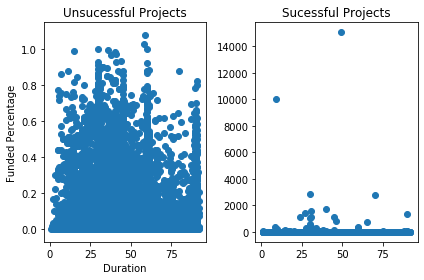

In [81]:
y1 = new_df[new_df['status_dummy']==0]['funded percentage']
y2 = new_df[new_df['status_dummy']==1]['funded percentage']

x1 = new_df[new_df['status_dummy']==0]['duration']
x2 = new_df[new_df['status_dummy']==1]['duration']

plt.subplot(1, 2, 1)
plt.scatter(x1, y1)
plt.xlabel('Duration')
plt.ylabel('Funded Percentage')
plt.title('Unsucessful Projects')

plt.subplot(1, 2, 2)
plt.scatter(x2, y2)
plt.title('Sucessful Projects')

plt.tight_layout()
plt.show()

In [82]:
print("Independent Variance\n----------")
print("Unsuccessful = ", x1.var())
print("Successful = ", x2.var())
print("\nDependent Variance\n----------")
print("Unsuccessful = ",y1.var())
print("Successful = ", y2.var())

Independent Variance
----------
Unsuccessful =  349.886916767045
Successful =  277.23816741709203

Dependent Variance
----------
Unsuccessful =  0.022541962935768396
Successful =  15704.233585570006


In [83]:
y = new_df[['duration',"status_dummy"]].groupby('status_dummy').mean()

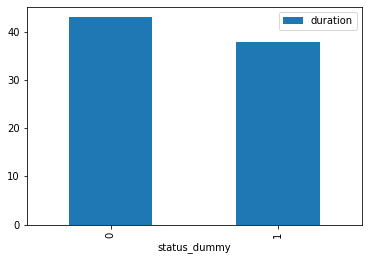

In [84]:
y.plot.bar()

## Check to see if project listing date is independent to month, day, year, and day of week
<p> The Chi-Square test is a statistical hypothesis test to check independence of categorical variables. In this context, we use this test to see if projects are more or less likely to be posted in certain months, on certain days, or in particular years. </p>

In [60]:
# We Reject the null that there is no difference between means - Month posted is jointly significant.
month_posted = new_df['project id'].groupby(new_df['month_posted_dummy']).count()
stats.chisquare(month_posted)

Power_divergenceResult(statistic=2776.5209005520896, pvalue=0.0)

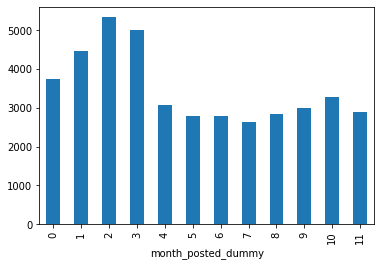

In [61]:
# It looks like most projects are posted in March (dummy = 2) and April (dummy = 3).
month_posted.plot.bar()

In [62]:
month_funded = new_df['project id'].groupby(new_df['month_funded_dummy']).count()
stats.chisquare(month_funded)

Power_divergenceResult(statistic=3348.6238617623862, pvalue=0.0)

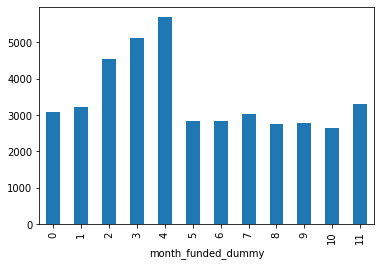

In [63]:
# Most projects end in March, April, and May.
month_funded.plot.bar()

In [64]:
day_posted = new_df['project id'].groupby(new_df['day_posted']).count()
stats.chisquare(day_posted)

Power_divergenceResult(statistic=664.074950407495, pvalue=1.4887333283985904e-120)

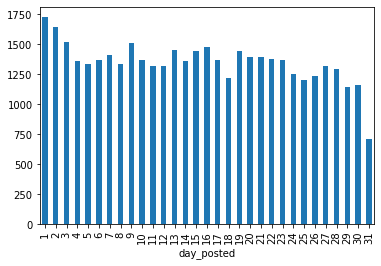

In [65]:
# Most projects are posted on the first of the month
day_posted.plot.bar()

In [66]:
day_funded = new_df['project id'].groupby(new_df['day_funded']).count()
stats.chisquare(day_funded)

Power_divergenceResult(statistic=2642.9375492937547, pvalue=0.0)

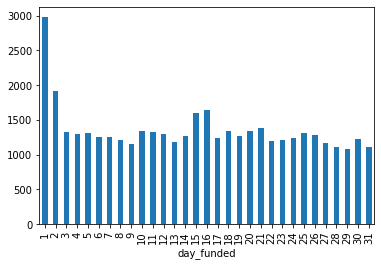

In [67]:
# Most projects end on the first of the month
day_funded.plot.bar()

In [68]:
year_posted = new_df['project id'].groupby(new_df['year_posted']).count()
stats.chisquare(year_posted)

Power_divergenceResult(statistic=19780.878540187856, pvalue=0.0)

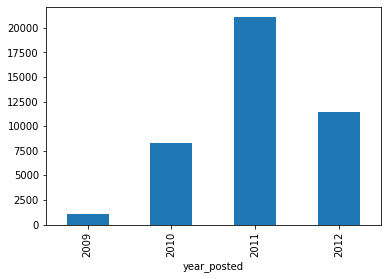

In [69]:
# 2011 saw the highest number of fundraisers on the platform (in the sample)
year_posted.plot.bar()

In [70]:
year_funded = new_df['project id'].groupby(new_df['year_funded']).count()
stats.chisquare(year_funded)

Power_divergenceResult(statistic=20089.310747831074, pvalue=0.0)

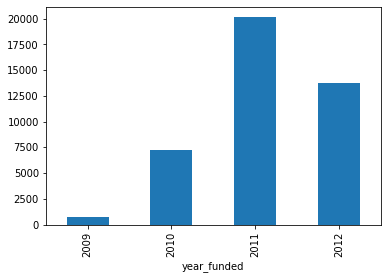

In [71]:
year_funded.plot.bar()

In [72]:
weekDay_posted = new_df['project id'].groupby(new_df['dayOfWeek_posted']).count()
stats.chisquare(weekDay_posted)

Power_divergenceResult(statistic=2879.8277765827775, pvalue=0.0)

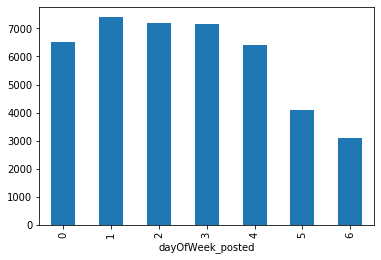

In [73]:
# Fundraisers are less likely to be posted on Fridays and Saturdays
weekDay_posted.plot.bar()

In [74]:
weekDay_funded = new_df['project id'].groupby(new_df['dayOfWeek_funded']).count()
stats.chisquare(weekDay_funded)

Power_divergenceResult(statistic=295.2817571281757, pvalue=8.387785658465541e-61)

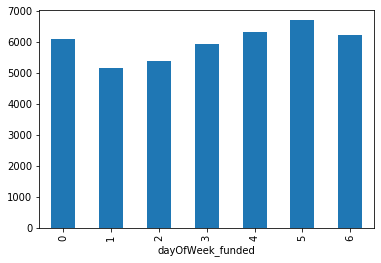

In [75]:
# Fundraisers are less likely to end on Mondays and Tuesdays
weekDay_funded.plot.bar()

## Check for joint significance of month, day of week, and year 
<p> Note: The F-test tests multiple hypothesis. The null hypothesis is that all slopes/coefficients are zero. Unfortunately the data isn't normally distributed so a parametric test probably isn't appropriate. </p>
<p> Month dummies: Jointly significant; Reject Null <br>
Year dummies: Jointly significant; Reject Null <br>
Day of week dummies: Not Jointly Significant; Do not reject the null

In [85]:
for each in ['posted', 'funded']:
    print(f'{each.capitalize()}:', stats.f_oneway(new_df['status_dummy'][new_df[f'month_{each}'] == 1], 
               new_df['status_dummy'][new_df[f'month_{each}'] == 2], 
               new_df['status_dummy'][new_df[f'month_{each}'] == 3],
              new_df['status_dummy'][new_df[f'month_{each}'] == 4],
              new_df['status_dummy'][new_df[f'month_{each}'] == 5],
              new_df['status_dummy'][new_df[f'month_{each}'] == 6],
              new_df['status_dummy'][new_df[f'month_{each}'] == 7],
              new_df['status_dummy'][new_df[f'month_{each}'] == 8],
              new_df['status_dummy'][new_df[f'month_{each}'] == 9],
              new_df['status_dummy'][new_df[f'month_{each}'] == 10],
              new_df['status_dummy'][new_df[f'month_{each}'] == 11],
              new_df['status_dummy'][new_df[f'month_{each}'] == 12]))

Posted: F_onewayResult(statistic=2.7794177318667224, pvalue=0.001290621161661944)
Funded: F_onewayResult(statistic=4.211975575580128, pvalue=2.8486971326095864e-06)


In [86]:
for each in ['posted', 'funded']:
    print(f'{each.capitalize()}:', stats.f_oneway(new_df['status_dummy'][new_df[f'year_{each}'] == 2009], 
               new_df['status_dummy'][new_df[f'year_{each}'] == 2010], 
               new_df['status_dummy'][new_df[f'year_{each}'] == 2011],
              new_df['status_dummy'][new_df[f'year_{each}'] == 2012]))

Posted: F_onewayResult(statistic=6.31445909442635, pvalue=0.0002814123156969091)
Funded: F_onewayResult(statistic=15.196937914090293, pvalue=7.012146438986875e-10)


In [87]:
for each in ['posted', 'funded']:
    print(f'{each.capitalize()}:', stats.f_oneway(new_df['status_dummy'][new_df[f'dayOfWeek_{each}'] == 0], 
               new_df['status_dummy'][new_df[f'dayOfWeek_{each}'] == 1], 
               new_df['status_dummy'][new_df[f'dayOfWeek_{each}'] == 2],
             new_df['status_dummy'][new_df[f'dayOfWeek_{each}'] == 3], 
              new_df['status_dummy'][new_df[f'dayOfWeek_{each}'] == 4],  
               new_df['status_dummy'][new_df[f'dayOfWeek_{each}'] == 5],
               new_df['status_dummy'][new_df[f'dayOfWeek_{each}'] == 6]))

Posted: F_onewayResult(statistic=7.054726074512105, pvalue=1.5977152142137403e-07)
Funded: F_onewayResult(statistic=1.4494149509388263, pvalue=0.1914102900357102)


## Kruskal-Wallis Test
#### Kruskal-Wallis test is a nonparametric version of the ANOVA test ; Interprets the MEDIAN difference

In [88]:
# Check for joint significance of Month 
for each in ['posted', 'funded']:
 
    stat, p = kruskal(new_df['status_dummy'][new_df[f'month_{each}'] == 1], 
               new_df['status_dummy'][new_df[f'month_{each}'] == 2], 
               new_df['status_dummy'][new_df[f'month_{each}'] == 3],
              new_df['status_dummy'][new_df[f'month_{each}'] == 4],
              new_df['status_dummy'][new_df[f'month_{each}'] == 5],
              new_df['status_dummy'][new_df[f'month_{each}'] == 6],
              new_df['status_dummy'][new_df[f'month_{each}'] == 7],
              new_df['status_dummy'][new_df[f'month_{each}'] == 8],
              new_df['status_dummy'][new_df[f'month_{each}'] == 9],
              new_df['status_dummy'][new_df[f'month_{each}'] == 10],
              new_df['status_dummy'][new_df[f'month_{each}'] == 11],
              new_df['status_dummy'][new_df[f'month_{each}'] == 12])
    print(f'{each.capitalize()} Statistics=%.3f, p=%.3f' % (stat, p))
    # interpret
    alpha = 0.01
    if p > alpha:
        print('Same distributions (fail to reject H0)')
    else:
        print('Different distributions (reject H0)')

Posted Statistics=30.559, p=0.001
Different distributions (reject H0)
Funded Statistics=46.293, p=0.000
Different distributions (reject H0)


In [89]:
# Check for joint significance of Year
for each in ['posted', 'funded']:
    stat, p = kruskal(new_df['status_dummy'][new_df[f'year_{each}'] == 2009], 
                    new_df['status_dummy'][new_df[f'year_{each}'] == 2010],
                    new_df['status_dummy'][new_df[f'year_{each}'] == 2011],
                    new_df['status_dummy'][new_df[f'year_{each}'] == 2012])
    print(f'{each.capitalize()} Statistics=%.3f, p=%.3f' % (stat, p))
    # interpret
    alpha = 0.01
    if p > alpha:
        print('Same distributions (fail to reject H0)')
    else:
        print('Different distributions (reject H0)')

Posted Statistics=18.936, p=0.000
Different distributions (reject H0)
Funded Statistics=45.544, p=0.000
Different distributions (reject H0)


In [90]:
# Check for joint significance of day of week
for each in ['posted', 'funded']:
    stat, p = kruskal(new_df['status_dummy'][new_df[f'dayOfWeek_{each}'] == 0], 
                   new_df['status_dummy'][new_df[f'dayOfWeek_{each}'] == 1], 
                   new_df['status_dummy'][new_df[f'dayOfWeek_{each}'] == 2],
                 new_df['status_dummy'][new_df[f'dayOfWeek_{each}'] == 3], 
                  new_df['status_dummy'][new_df[f'dayOfWeek_{each}'] == 4],  
                   new_df['status_dummy'][new_df[f'dayOfWeek_{each}'] == 5],
                   new_df['status_dummy'][new_df[f'dayOfWeek_{each}'] == 6])
    print(f'{each.capitalize()} Statistics=%.3f, p=%.3f' % (stat, p))
    # interpret
    alpha = 0.01
    if p > alpha:
        print('Same distributions (fail to reject H0)')
    else:
        print('Different distributions (reject H0)')

Posted Statistics=42.292, p=0.000
Different distributions (reject H0)
Funded Statistics=8.696, p=0.191
Same distributions (fail to reject H0)


## Dunn's Test
<p>Note: Dunn's test pinpoints which means are significantly different than the others </p>
<p> This section conducts the Dunn's test between 'status_dummy' and 'month', 'year', 'day of week' and 'year_month.' </p>


In [91]:
# It looks like the means of January and February are statistically different at 95% confidence
scikit_posthocs.posthoc_dunn(new_df, val_col='status_dummy', group_col='month_posted', p_adjust='bonferroni')

,1,2,3,4,5,6,7,8,9,10,11,12
1,1.000000,0.027101,0.680131,1.0,1.000000,1.000000,1.0,1.0,1.000000,0.158743,1.000000,1.000000
2,0.027101,1.000000,1.000000,1.0,0.063191,0.202866,1.0,1.0,0.544404,1.000000,0.667578,0.126044
3,0.680131,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1.000000,1.000000
4,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1.000000,1.000000
5,1.000000,0.063191,1.000000,1.0,1.000000,1.000000,1.0,1.0,1.000000,0.276478,1.000000,1.000000
6,1.000000,0.202866,1.000000,1.0,1.000000,1.000000,1.0,1.0,1.000000,0.672972,1.000000,1.000000
7,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1.000000,1.000000
8,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1.000000,1.000000
9,1.000000,0.544404,1.000000,1.0,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1.000000,1.000000
10,0.158743,1.000000,1.000000,1.0,0.276478,0.672972,1.0,1.0,1.000000,1.000000,1.000000,0.467064


In [92]:
# The mean success between April and December are statistically significant at 99% confidence
# March and December at 99% confidence
# March and May at 95% confidence
# April and May at 99% confidence
# April and July at 95% confidence
# April and December at 99% confidence
# May and November at 95% confidence
# November and December at 99% confidence
scikit_posthocs.posthoc_dunn(new_df, val_col='status_dummy', group_col='month_funded', p_adjust='bonferroni')

,1,2,3,4,5,6,7,8,9,10,11,12
1,1.000000,1.0,0.269449,0.083151,1.000000,1.000000,1.000000,1.0,1.0,1.0,0.228951,1.000000
2,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.000000,1.000000
3,0.269449,1.0,1.000000,1.000000,0.023152,0.838899,0.085376,1.0,1.0,1.0,1.000000,0.005146
4,0.083151,1.0,1.000000,1.000000,0.003695,0.311561,0.023809,1.0,1.0,1.0,1.000000,0.000948
5,1.000000,1.0,0.023152,0.003695,1.000000,1.000000,1.000000,1.0,1.0,1.0,0.034919,1.000000
6,1.000000,1.0,0.838899,0.311561,1.000000,1.000000,1.000000,1.0,1.0,1.0,0.627222,1.000000
7,1.000000,1.0,0.085376,0.023809,1.000000,1.000000,1.000000,1.0,1.0,1.0,0.080245,1.000000
8,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.000000,1.000000
9,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.000000,1.000000
10,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.000000,1.000000


In [93]:
# 2010 and 2011 are significantly different 
# 2011 and 2012 are significantly different
scikit_posthocs.posthoc_dunn(new_df, val_col='status_dummy', group_col='year_posted', p_adjust='bonferroni')

,2009,2010,2011,2012
2009,1.0,1.000000,1.000000,1.00000
2010,1.0,1.000000,0.007564,1.00000
2011,1.0,0.007564,1.000000,0.00093
2012,1.0,1.000000,0.000930,1.00000


In [94]:
# 2011 and 2010
# 2011 and 2012
scikit_posthocs.posthoc_dunn(new_df, val_col='status_dummy', group_col='year_funded', p_adjust='bonferroni')

,2009,2010,2011,2012
2009,1.000000,1.000000,4.511020e-01,1.000000e+00
2010,1.000000,1.000000,1.095175e-03,9.969441e-01
2011,0.451102,0.001095,1.000000e+00,6.314071e-10
2012,1.000000,0.996944,6.314071e-10,1.000000e+00


In [95]:
# It may be better to post on a Sunday, Monday, or Tuesday than a Friday or Saturday 
scikit_posthocs.posthoc_dunn(new_df, val_col='status_dummy', group_col='dayOfWeek_posted', p_adjust='bonferroni')

,0,1,2,3,4,5,6
0,1.000000,1.000000,1.000000,0.628016,0.067526,0.000672,0.002054
1,1.000000,1.000000,1.000000,0.340379,0.029403,0.000233,0.000875
2,1.000000,1.000000,1.000000,1.000000,0.149575,0.001643,0.004611
3,0.628016,0.340379,1.000000,1.000000,1.000000,0.410119,0.548987
4,0.067526,0.029403,0.149575,1.000000,1.000000,1.000000,1.000000
5,0.000672,0.000233,0.001643,0.410119,1.000000,1.000000,1.000000
6,0.002054,0.000875,0.004611,0.548987,1.000000,1.000000,1.000000


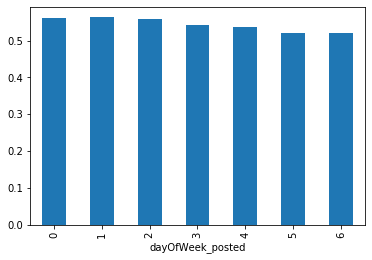

In [96]:
weekDayPosted = new_df['status_dummy'].groupby(new_df['dayOfWeek_posted']).mean()
weekDayPosted.plot.bar()

In [97]:
scikit_posthocs.posthoc_dunn(new_df, val_col='status_dummy', group_col='dayOfWeek_funded', p_adjust='bonferroni')

,0,1,2,3,4,5,6
0,1.000000,0.405313,1.0,1.000000,0.864544,1.0,1.0
1,0.405313,1.000000,1.0,0.872227,1.000000,1.0,1.0
2,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.0
3,1.000000,0.872227,1.0,1.000000,1.000000,1.0,1.0
4,0.864544,1.000000,1.0,1.000000,1.000000,1.0,1.0
5,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.0
6,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.0


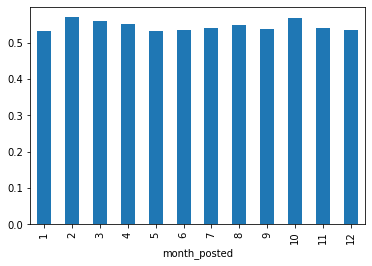

In [98]:
month_posted = new_df['status_dummy'].groupby(new_df['month_posted']).mean()
month_posted.plot.bar()

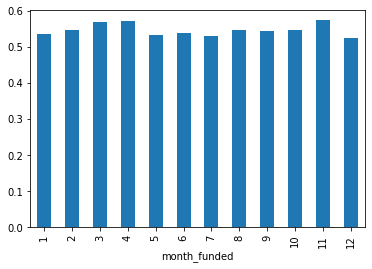

In [99]:
month_funded = new_df['status_dummy'].groupby(new_df['month_funded']).mean()
month_funded.plot.bar()

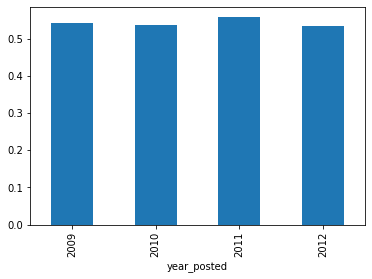

In [100]:
year_posted = new_df['status_dummy'].groupby(new_df['year_posted']).mean()
year_posted.plot.bar()

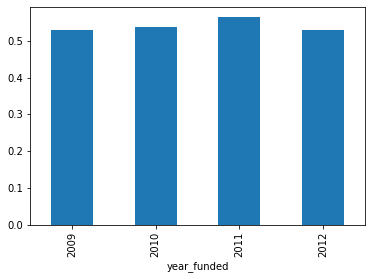

In [101]:
year_funded = new_df['status_dummy'].groupby(new_df['year_funded']).mean()
year_funded.plot.bar()

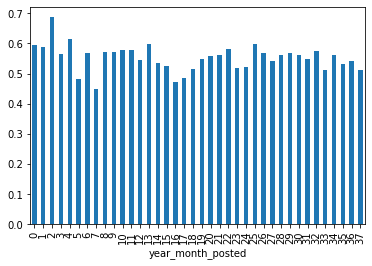

In [102]:
year_month_posted = new_df['status_dummy'].groupby(new_df['year_month_posted']).mean()
year_month_posted.plot.bar()

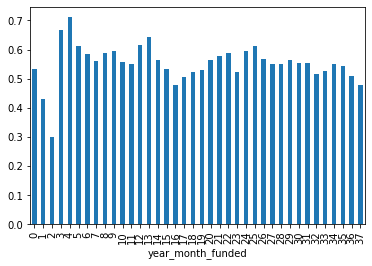

In [103]:
year_month_funded = new_df['status_dummy'].groupby(new_df['year_month_funded']).mean()
year_month_funded.plot.bar()

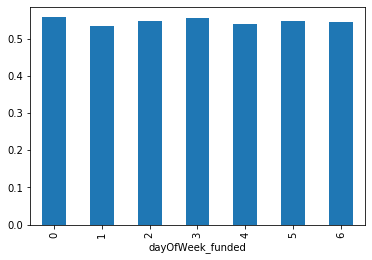

In [104]:
weekDayFunded = new_df['status_dummy'].groupby(new_df['dayOfWeek_funded']).mean()
weekDayFunded.plot.bar()

### Look at the distribution of variables

In [105]:
X = new_df[['year_funded_dummy', 'year_posted_dummy', 'month_funded_dummy', 'month_posted_dummy', 
            'year_month_funded', 'year_month_posted', 'category_dummy', 'subcategory_dummy','country_dummy', 'duration', 
           'day_funded', 'day_posted','dayOfWeek_posted', 'dayOfWeek_funded', 'goal']]
y = new_df['status_dummy']

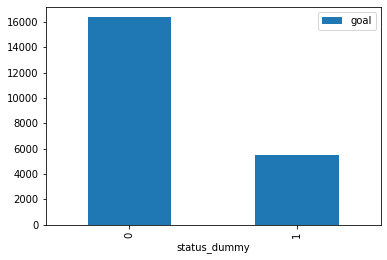

In [106]:
#On average, successful projects set lower goals
new_df[['status_dummy','goal']].groupby('status_dummy').mean().plot.bar()

In [107]:
new_df['status_dummy'].value_counts()

1    22902
0    18939
Name: status_dummy, dtype: int64

(array([18939., 22902.]), array([0. , 0.5, 1. ]), <a list of 2 Patch objects>)

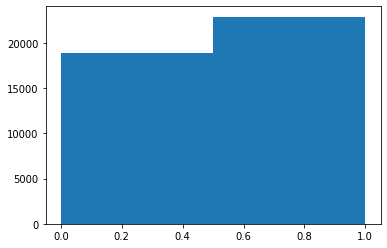

In [108]:
plt.hist(new_df['status_dummy'].T, bins=len(new_df['status_dummy'].value_counts()))

(array([  700.,  7231., 20124., 13786.]),
 array([0.  , 0.75, 1.5 , 2.25, 3.  ]),
 <a list of 4 Patch objects>)

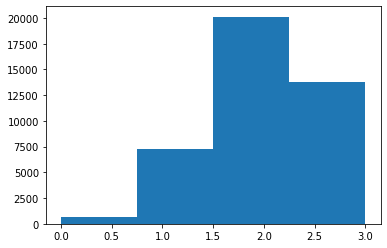

In [109]:
plt.hist(new_df['year_funded_dummy'].T, bins=len(new_df['year_funded_dummy'].value_counts()))

(array([ 1031.,  8309., 21063., 11438.]),
 array([0.  , 0.75, 1.5 , 2.25, 3.  ]),
 <a list of 4 Patch objects>)

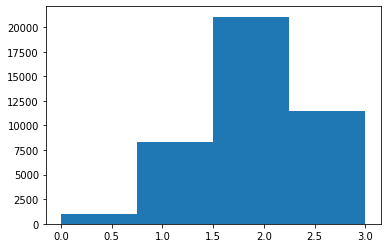

In [110]:
plt.hist(new_df['year_posted_dummy'].T, bins=len(new_df['year_posted_dummy'].value_counts()))

(array([3093., 3224., 4539., 5108., 5696., 2840., 2841., 3037., 2748.,
        2789., 2634., 3292.]),
 array([ 0.        ,  0.91666667,  1.83333333,  2.75      ,  3.66666667,
         4.58333333,  5.5       ,  6.41666667,  7.33333333,  8.25      ,
         9.16666667, 10.08333333, 11.        ]),
 <a list of 12 Patch objects>)

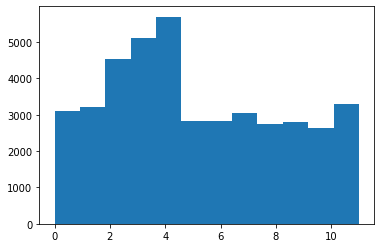

In [111]:
plt.hist(new_df['month_funded_dummy'].T, bins=len(new_df['month_funded_dummy'].value_counts()))

(array([3749., 4475., 5337., 4995., 3082., 2781., 2776., 2644., 2840.,
        2982., 3280., 2900.]),
 array([ 0.        ,  0.91666667,  1.83333333,  2.75      ,  3.66666667,
         4.58333333,  5.5       ,  6.41666667,  7.33333333,  8.25      ,
         9.16666667, 10.08333333, 11.        ]),
 <a list of 12 Patch objects>)

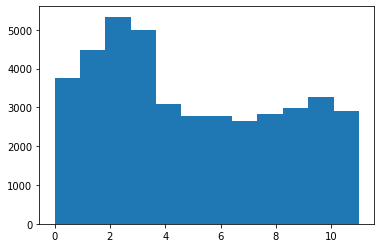

In [112]:
plt.hist(new_df['month_posted_dummy'].T, bins=len(new_df['month_posted_dummy'].value_counts()))

(array([ 163.,  223.,   10.,   24.,   52.,   49.,   65.,  114.,  168.,
         173.,  844.,  975.,  241.,  312.,  448.,  603.,  882.,  890.,
         847.,  848.,  957., 1017., 1627., 2094., 1400., 1649., 1889.,
        1823., 1907., 2098., 1836., 1827., 1968., 2034., 2898., 3147.,
        3349.,  390.]),
 array([ 0.        ,  0.97368421,  1.94736842,  2.92105263,  3.89473684,
         4.86842105,  5.84210526,  6.81578947,  7.78947368,  8.76315789,
         9.73684211, 10.71052632, 11.68421053, 12.65789474, 13.63157895,
        14.60526316, 15.57894737, 16.55263158, 17.52631579, 18.5       ,
        19.47368421, 20.44736842, 21.42105263, 22.39473684, 23.36842105,
        24.34210526, 25.31578947, 26.28947368, 27.26315789, 28.23684211,
        29.21052632, 30.18421053, 31.15789474, 32.13157895, 33.10526316,
        34.07894737, 35.05263158, 36.02631579, 37.        ]),
 <a list of 38 Patch objects>)

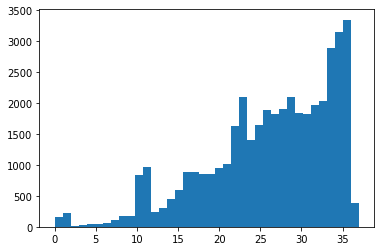

In [113]:
plt.hist(new_df['year_month_funded'].T, bins=len(new_df['year_month_funded'].value_counts()))

(array([ 182.,  163.,   16.,   55.,   52.,   58.,   88.,  270.,  147.,
         233.,  295., 1007.,  980.,  412.,  536.,  592.,  886.,  839.,
         741.,  832.,  956., 1241., 1450., 2091., 1757., 1688., 1837.,
        1845., 1843., 1879., 1815., 1738., 1879., 2275., 2730., 3237.,
        2606.,  590.]),
 array([ 0.        ,  0.97368421,  1.94736842,  2.92105263,  3.89473684,
         4.86842105,  5.84210526,  6.81578947,  7.78947368,  8.76315789,
         9.73684211, 10.71052632, 11.68421053, 12.65789474, 13.63157895,
        14.60526316, 15.57894737, 16.55263158, 17.52631579, 18.5       ,
        19.47368421, 20.44736842, 21.42105263, 22.39473684, 23.36842105,
        24.34210526, 25.31578947, 26.28947368, 27.26315789, 28.23684211,
        29.21052632, 30.18421053, 31.15789474, 32.13157895, 33.10526316,
        34.07894737, 35.05263158, 36.02631579, 37.        ]),
 <a list of 38 Patch objects>)

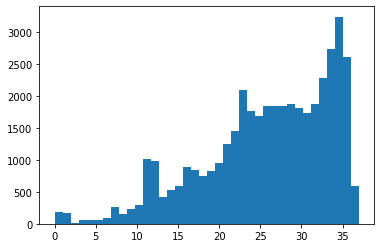

In [114]:
plt.hist(new_df['year_month_posted'].T, bins=len(new_df['year_month_posted'].value_counts()))

(array([ 3684.,   965.,   704.,  1561.,  1018., 12550.,  1291.,  1460.,
        10031.,  1380.,  4150.,   732.,  2315.]),
 array([ 0.        ,  0.92307692,  1.84615385,  2.76923077,  3.69230769,
         4.61538462,  5.53846154,  6.46153846,  7.38461538,  8.30769231,
         9.23076923, 10.15384615, 11.07692308, 12.        ]),
 <a list of 13 Patch objects>)

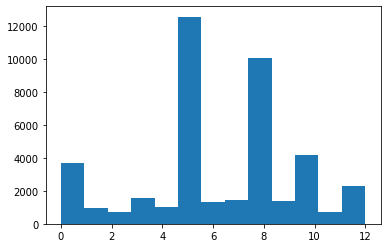

In [115]:
plt.hist(new_df['category_dummy'].T, bins=len(new_df['category_dummy'].value_counts()))

(array([ 376., 1008.,  301.,  471.,  542.,  430.,  965.,  167.,  987.,
         228.,  704.,  260.,  134., 3674.,  269., 1018.,  943., 2333.,
        1291.,  239.,  163.,  420.,  187., 1812.,  414.,  404.,  407.,
        3000., 1408.,  881.,  170.,  234.,  483.,  460.,  263., 1380.,
         200.,  690.,  910.,  509.,  616., 1627.,  329., 3735.,  328.,
        2315.,  750., 1024.,  382.]),
 array([ 0.        ,  0.97959184,  1.95918367,  2.93877551,  3.91836735,
         4.89795918,  5.87755102,  6.85714286,  7.83673469,  8.81632653,
         9.79591837, 10.7755102 , 11.75510204, 12.73469388, 13.71428571,
        14.69387755, 15.67346939, 16.65306122, 17.63265306, 18.6122449 ,
        19.59183673, 20.57142857, 21.55102041, 22.53061224, 23.51020408,
        24.48979592, 25.46938776, 26.44897959, 27.42857143, 28.40816327,
        29.3877551 , 30.36734694, 31.34693878, 32.32653061, 33.30612245,
        34.28571429, 35.26530612, 36.24489796, 37.2244898 , 38.20408163,
        39.18367347, 40

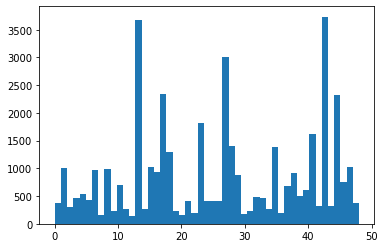

In [116]:
plt.hist(new_df['subcategory_dummy'].T, bins=len(new_df['subcategory_dummy'].value_counts()))

(array([2978., 1916., 1321., 1301., 1317., 1254., 1252., 1207., 1157.,
        1333., 1321., 1292., 1180., 1265., 1601., 1648., 1232., 1344.,
        1273., 1341., 1386., 1192., 1207., 1238., 1316., 1278., 1168.,
        1110., 1076., 1223., 1114.]),
 array([ 1.        ,  1.96774194,  2.93548387,  3.90322581,  4.87096774,
         5.83870968,  6.80645161,  7.77419355,  8.74193548,  9.70967742,
        10.67741935, 11.64516129, 12.61290323, 13.58064516, 14.5483871 ,
        15.51612903, 16.48387097, 17.4516129 , 18.41935484, 19.38709677,
        20.35483871, 21.32258065, 22.29032258, 23.25806452, 24.22580645,
        25.19354839, 26.16129032, 27.12903226, 28.09677419, 29.06451613,
        30.03225806, 31.        ]),
 <a list of 31 Patch objects>)

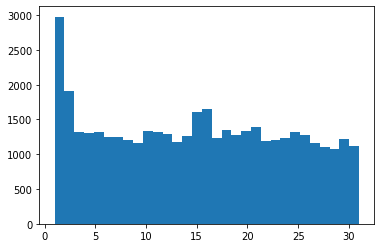

In [117]:
plt.hist(new_df['day_funded'].T, bins=len(new_df['day_funded'].value_counts()))

(array([1727., 1646., 1515., 1362., 1338., 1372., 1409., 1338., 1514.,
        1368., 1317., 1322., 1449., 1361., 1442., 1480., 1371., 1218.,
        1447., 1395., 1396., 1377., 1366., 1249., 1198., 1239., 1321.,
        1293., 1142., 1158.,  711.]),
 array([ 1.        ,  1.96774194,  2.93548387,  3.90322581,  4.87096774,
         5.83870968,  6.80645161,  7.77419355,  8.74193548,  9.70967742,
        10.67741935, 11.64516129, 12.61290323, 13.58064516, 14.5483871 ,
        15.51612903, 16.48387097, 17.4516129 , 18.41935484, 19.38709677,
        20.35483871, 21.32258065, 22.29032258, 23.25806452, 24.22580645,
        25.19354839, 26.16129032, 27.12903226, 28.09677419, 29.06451613,
        30.03225806, 31.        ]),
 <a list of 31 Patch objects>)

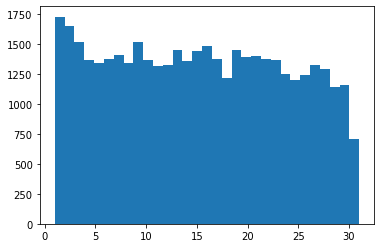

In [118]:
plt.hist(new_df['day_posted'].T, bins=len(new_df['day_posted'].value_counts()))

(array([6521., 7395., 7183., 7148., 6415., 4084., 3095.]),
 array([0.        , 0.85714286, 1.71428571, 2.57142857, 3.42857143,
        4.28571429, 5.14285714, 6.        ]),
 <a list of 7 Patch objects>)

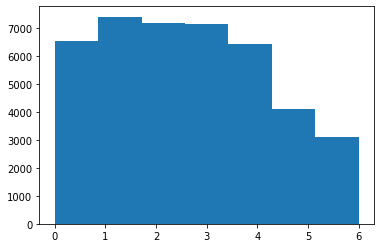

In [119]:
plt.hist(new_df['dayOfWeek_posted'].T, bins=len(new_df['dayOfWeek_posted'].value_counts()))

(array([6111., 5151., 5376., 5950., 6312., 6698., 6243.]),
 array([0.        , 0.85714286, 1.71428571, 2.57142857, 3.42857143,
        4.28571429, 5.14285714, 6.        ]),
 <a list of 7 Patch objects>)

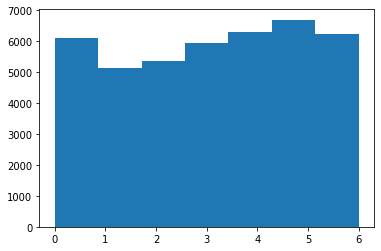

In [120]:
plt.hist(new_df['dayOfWeek_funded'].T, bins=len(new_df['dayOfWeek_funded'].value_counts()))